In [1]:
#! /usr/bin/env python3
import importlib
import inspect
import pprint
import os
from pathlib import Path

#
from Pegasus.api import *
pegasus_graphviz = importlib.import_module("pegasus-graphviz")

import graphviz as graphviz
import pygraphviz as pgv

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
# from IPython.display import Image
# from IPython.display import IFrame
from wand.image import Image as WImage

In [4]:
importlib.reload(pegasus_graphviz)

# rrdl = remove redundant dependency links
def display_workflow(workflow_file, rrdl, display_files, leftright):
    #print(dir(workflow_file))
    dot_file = Path(workflow_file).with_suffix('.dot')
    # invoke emit_dot on the workflow : show file input/outputs
    dag = pegasus_graphviz.parse_yamlfile(workflow_file, include_files=display_files)
    
    #pegasus_graphviz.remove_xforms(dag, 'L_0')
    
    if rrdl:
        # remove redundant dependency links
        dag = pegasus_graphviz.transitivereduction(dag)

    # labeloptions = ["label", "xform", "id", "xform-id", "label-xform", "label-id"]
    dot = pegasus_graphviz.emit_dot(dag, label_type='node_label', outfile=dot_file, leftright=leftright)

    s = graphviz.Source.from_file(dot_file)
    image_file = graphviz.render(filepath=dot_file, engine='dot', format='pdf')
    return image_file # Image(filename=image_file)

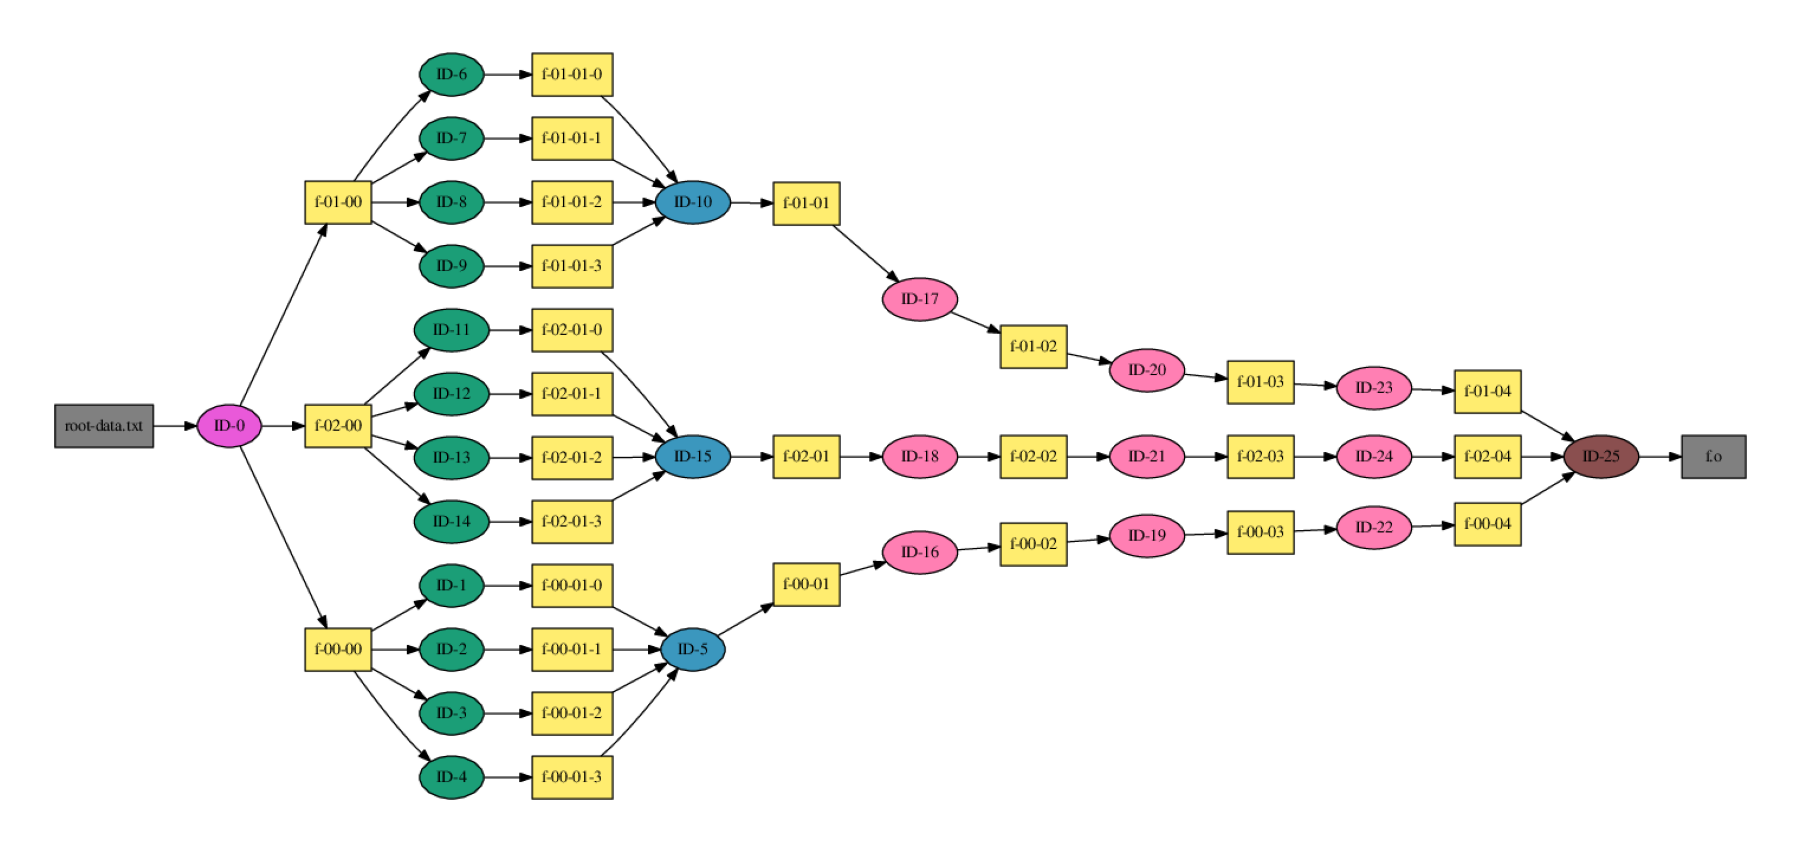

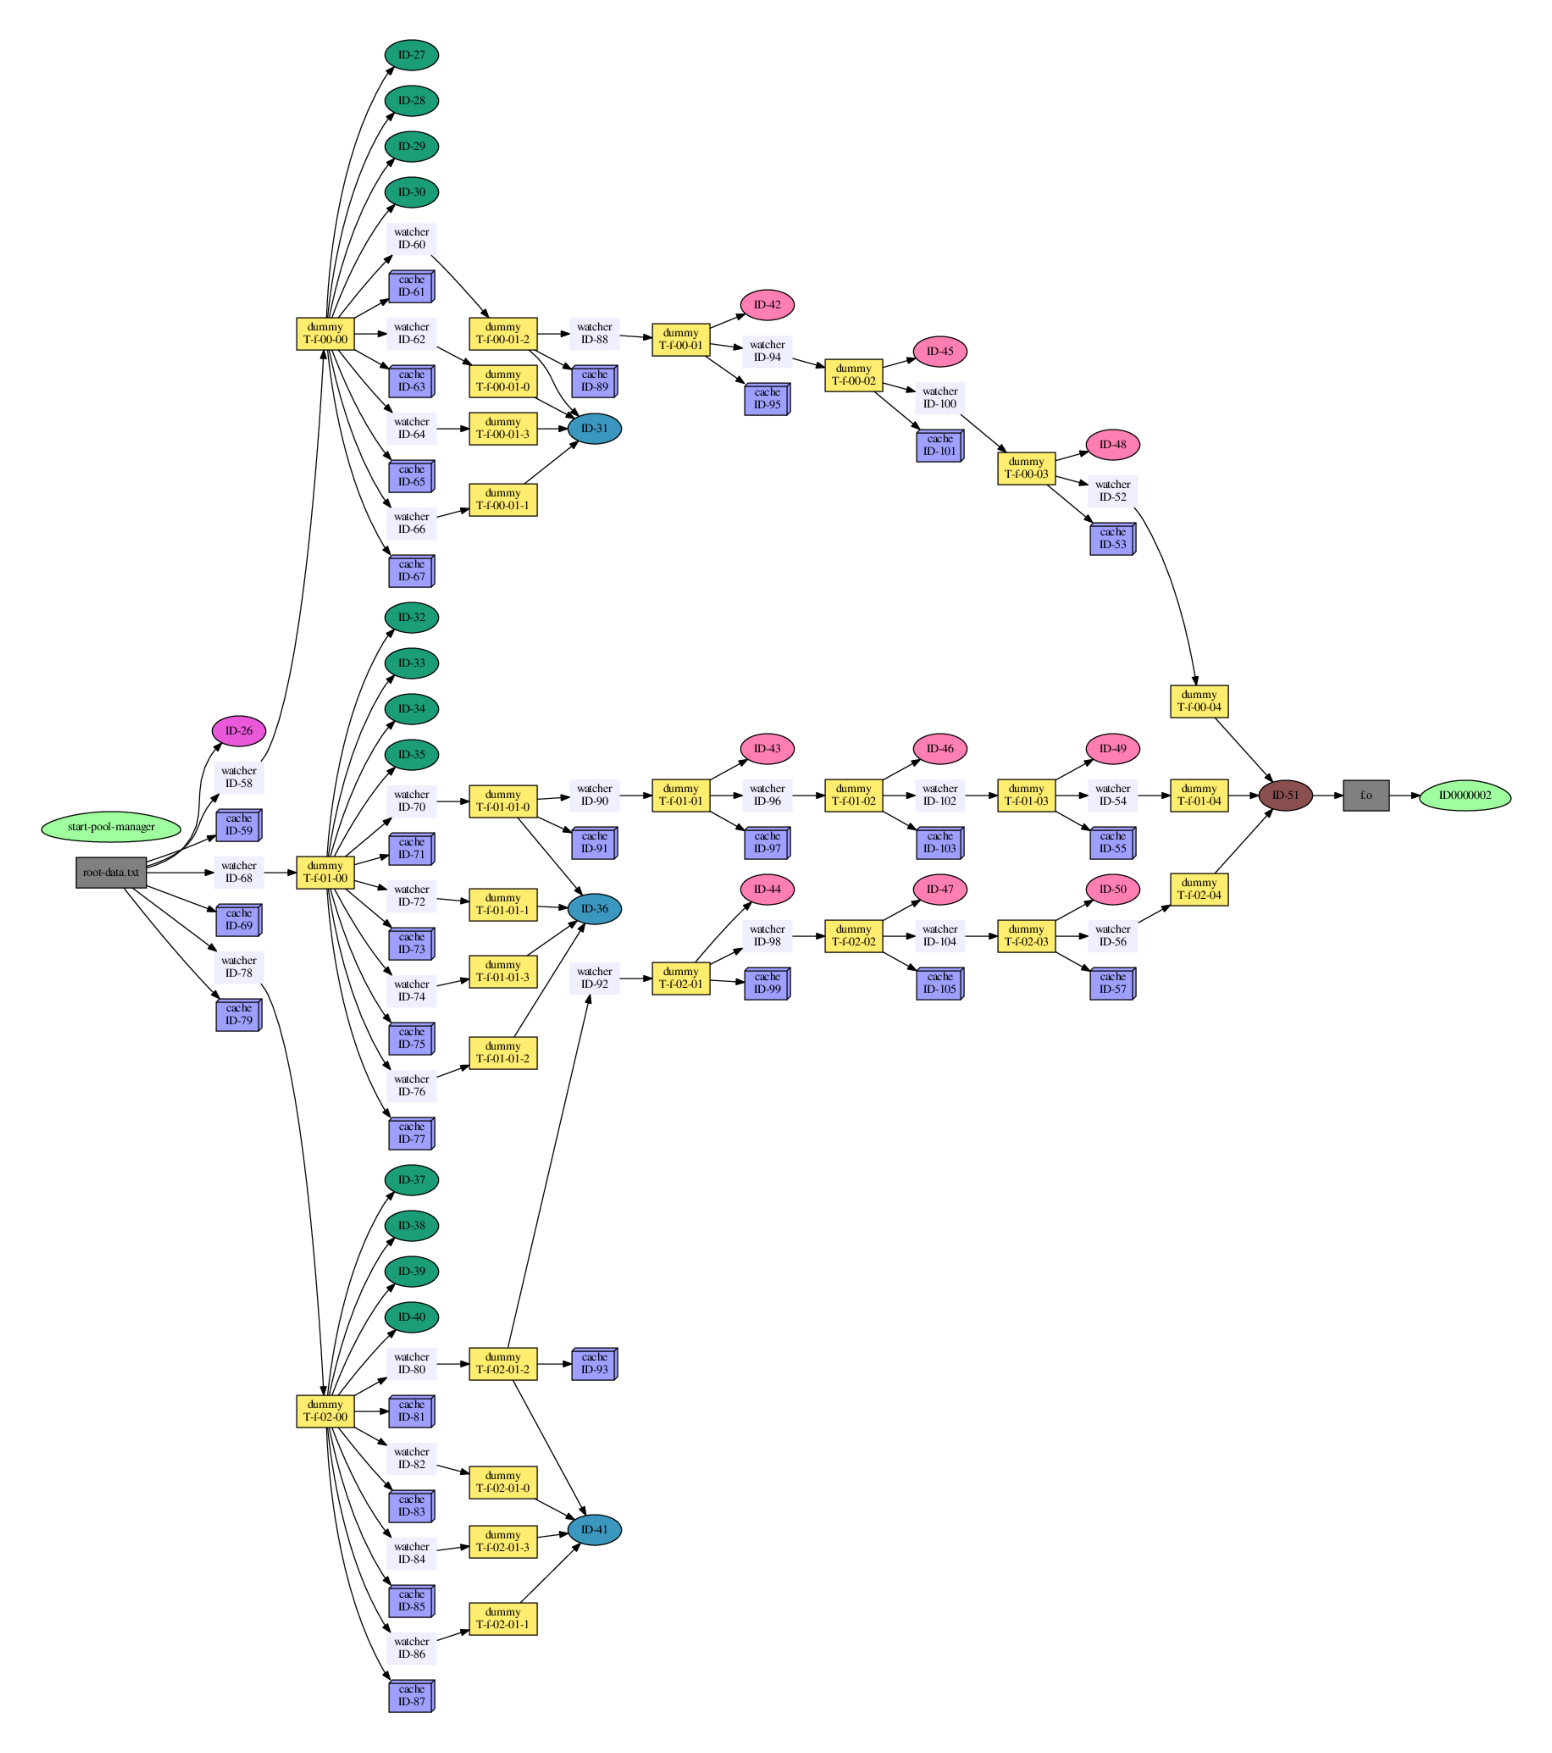

In [6]:
# ---------------------------------------
# cdo_dependencies : false, CDOs are not matched between in/out so CDO consumers do not depend on producers, the DAG is split
#                  : true, CDOs behave like files and trigger dependencies
# display_files : true, files appear as nodes in the graph, otherwise not
# transitive_reduction : true - remove links that are superfluous - transitive, between job-job bypassing files

# cdo_dependencies must be False when executing a CDO enabled workflow

cdo_dependencies     = False
display_files        = True
transitive_reduction = True
left_right           = True
   
file1 = 'demo-orig.yml'
I1 = display_workflow(file1, transitive_reduction, display_files, left_right)

file2 = 'demo-maestro.yml'
I2 = display_workflow(file2, transitive_reduction, display_files, left_right ) # left_right and cdo_dependencies)

# ---------------------------------------
# rename pdf files based on what options we used to generate the DAG pics
fstring  = "-cdo" if cdo_dependencies else ""
fstring += "-files" if display_files else ""
fstring += "-reduced" if transitive_reduction else ""
image_name1 = I1.replace('.dot.pdf', fstring + '.pdf')
image_name2 = I2.replace('.dot.pdf', fstring + '.pdf')
os.rename(I1, image_name1)
os.rename(I2, image_name2)

# ---------------------------------------
# read+convert PDFs into images
img_A = WImage(filename=image_name1)
img_B = WImage(filename=image_name2)

# ---------------------------------------
# figure size in inches optional
rcParams['figure.figsize'] = 32, 32
# ---------------------------------------
# display images in notebook
fig, ax = plt.subplots(1,1)
ax.imshow(img_A);
ax.set_axis_off()
fig, ax = plt.subplots(1,1)
ax.imshow(img_B);
ax.set_axis_off()